In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import os
import time
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATASET_PATH='..\..\dataset\preprocesd_cicids.csv'
print(DATASET_PATH)

..\..\dataset\preprocesd_cicids.csv


In [4]:
# ,nrows=10000, header=0
start = time.time()
df=pd.read_csv(DATASET_PATH)
df.head()
print("Time taken to load the data: ", time.time()-start," seconds")

Time taken to load the data:  34.21541118621826  seconds


In [5]:
df.to_feather('output.feather')

In [6]:
import pyarrow.feather as feather

# Read the Feather file into a pandas DataFrame
start = time.time()
df = feather.read_feather('./output.feather')
print("Time taken to load the data: ", time.time()-start," seconds")
# Display the DataFrame
df.head()

Time taken to load the data:  1.6995484828948975  seconds


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
df.shape

(2520798, 79)

In [8]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
              colname = corr_matrix.columns[i]
              col_corr.add(colname)
    return col_corr

In [9]:
corr_features = correlation(df, 0.85)
corr_features

{' Active Min',
 ' Average Packet Size',
 ' Avg Bwd Segment Size',
 ' Avg Fwd Segment Size',
 ' Bwd IAT Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' CWE Flag Count',
 ' ECE Flag Count',
 ' Flow IAT Max',
 ' Fwd Header Length.1',
 ' Fwd IAT Max',
 ' Fwd IAT Mean',
 ' Fwd IAT Min',
 ' Fwd IAT Std',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 ' Idle Max',
 ' Idle Min',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' SYN Flag Count',
 ' Subflow Bwd Bytes',
 ' Subflow Bwd Packets',
 ' Subflow Fwd Bytes',
 ' Total Backward Packets',
 ' Total Length of Bwd Packets',
 ' act_data_pkt_fwd',
 ' min_seg_size_forward',
 'Fwd IAT Total',
 'Fwd Packets/s',
 'Idle Mean',
 'Subflow Fwd Packets'}

In [10]:
df.drop(corr_features,axis=1,inplace=True)

In [11]:
df.shape

(2520798, 44)

In [12]:
# create a Series with the count of rows in each group
label_counts = df[' Label'].value_counts()

# create a list of labels that have less than 10,000 rows
labels_to_merge = label_counts[label_counts < 3000].index.tolist()
print(labels_to_merge)

['Bot', 'Web Attack � Brute Force', 'Web Attack � XSS', 'Infiltration', 'Web Attack � Sql Injection', 'Heartbleed']


In [13]:
# create a new label called 'Other' and merge the labels with less than 10,000 rows
df[' Label'] = df[' Label'].apply(lambda x: 'Other' if x in labels_to_merge else x)
# group the rows by the new 'Label' column
grouped_df = df.groupby(' Label')

In [14]:
df.shape

(2520798, 44)

In [15]:
df[' Label'].value_counts()

 Label
BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
Other                  4138
SSH-Patator            3219
Name: count, dtype: int64

In [16]:
x = df.drop([' Label'],axis=1)
y = df[' Label']

In [17]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(x, y)
Xn, yn = rus.fit_resample(x, y)
# Xn.value_counts()

In [18]:
Xn.shape

(32190, 43)

In [19]:
yn.shape

(32190,)

In [20]:
yn.value_counts()

 Label
BENIGN              3219
DDoS                3219
DoS GoldenEye       3219
DoS Hulk            3219
DoS Slowhttptest    3219
DoS slowloris       3219
FTP-Patator         3219
Other               3219
PortScan            3219
SSH-Patator         3219
Name: count, dtype: int64

In [21]:
#z-score   z = (x - mean) / std
# it can make it easier for the algorithm to learn meaningful patterns in the data
cols = list(Xn.columns)
for col in cols:
    Xn[col] = stats.zscore(Xn[col])

In [22]:
Xn.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,...,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Idle Std
1029337,-0.263616,-0.707781,-0.069969,-0.037641,-0.278349,0.352479,-0.530286,2.687514,-0.022664,-0.158127,...,NaN,NaN,NaN,NaN,-1.116079,-0.276731,-0.332643,-0.198419,-0.342221,-0.280617
2454275,5.566419,-0.709415,-0.120401,-0.042799,-0.324996,-0.115027,-0.563196,-0.188982,-0.023023,0.067566,...,NaN,NaN,NaN,NaN,-1.052714,-0.244825,-0.332643,-0.198419,-0.342221,-0.280617
440854,-0.260863,2.309030,0.131756,-0.023235,0.247642,-0.115027,-0.442882,-0.188982,-0.023022,-0.159054,...,NaN,NaN,NaN,NaN,-0.543073,0.380396,-0.306772,-0.168252,-0.277858,-0.278543
438438,-0.223847,-0.561542,-0.002728,-0.025147,0.022447,-0.115027,-0.046554,-0.188982,-0.022969,-0.159033,...,NaN,NaN,NaN,NaN,-0.543073,-0.260084,-0.182565,-0.198419,-0.218966,-0.280617
2307425,-0.263616,-0.708802,-0.120401,-0.040664,-0.247787,0.658776,-0.517901,3.770066,-0.022467,-0.158233,...,NaN,NaN,NaN,NaN,-1.116079,-0.276731,-0.332643,-0.198419,-0.342221,-0.280617


In [23]:
from sklearn.model_selection import  train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Xn,yn,test_size=0.20,random_state=0)

In [24]:
print(np.any(np.isnan(X_train)))
print(np.all(np.isfinite(X_train)))

True
False


In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create an instance of SimpleImputer with 'mean' strategy to replace NaN values
imputer = SimpleImputer(strategy='mean', keep_empty_features=True)

# Fit the imputer to X_train and transform X_train and X_test with it
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply StandardScaler to X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# model training USING KNN (suppor vector machine)
start = time.time()
k = 10 # number of nearest neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
print("Time taken to train model: ", time.time()-start," seconds")

Time taken to train model:  0.04434347152709961  seconds


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics


# performance metrics calculation of our model over training data set
start = time.time()
Predict_X =  knn.predict(X_train)
scores = cross_val_score(knn, X_train, Y_train, cv=7)
accuracy = metrics.accuracy_score(Y_train,Predict_X)
confusion_matrix = metrics.confusion_matrix(Y_train, Predict_X)
classification = metrics.classification_report(Y_train, Predict_X, digits=3)
print("Time taken to for performance matric calculation: ", time.time()-start," seconds")

Time taken to for performance matric calculation:  6.9465742111206055  seconds


In [28]:
print()
print('--------------------------- Results --------------------------------')
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification)
print()


--------------------------- Results --------------------------------

Cross Validation Mean Score:
 0.9792637915638396

Model Accuracy:
 0.9835352593973283

Confusion matrix:
 [[2383    4   17   15   12    6   11   76   43   14]
 [   2 2592    2    5    0    0    0    0    0    0]
 [   0    0 2581    2    2    1    3    0    0    0]
 [   9    2    8 2564    0    0    0    1    0    0]
 [   4    0    1    0 2535   15    0    4    0    4]
 [   5    0    3    0   14 2570    0    0    0    1]
 [   6    0    0    0    0    4 2487    0    1    1]
 [  12    1   16    0    0    0    1 2510    8   38]
 [   5    0    1    3    0    6    0    3 2538    0]
 [   9    0    3    3    0    4    5    7    1 2568]]

Classification report:
                   precision    recall  f1-score   support

          BENIGN      0.979     0.923     0.950      2581
            DDoS      0.997     0.997     0.997      2601
   DoS GoldenEye      0.981     0.997     0.989      2589
        DoS Hulk      0.989     0.

In [29]:
def plot_confusion_matrix(cm,title,cmap=None,target=None,normalize=False):

    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target is not None:
        ticks = np.arange(len(target))
        plt.xticks(ticks, target, rotation=45)
        plt.yticks(ticks, target)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title, bbox_inches='tight', dpi=300)

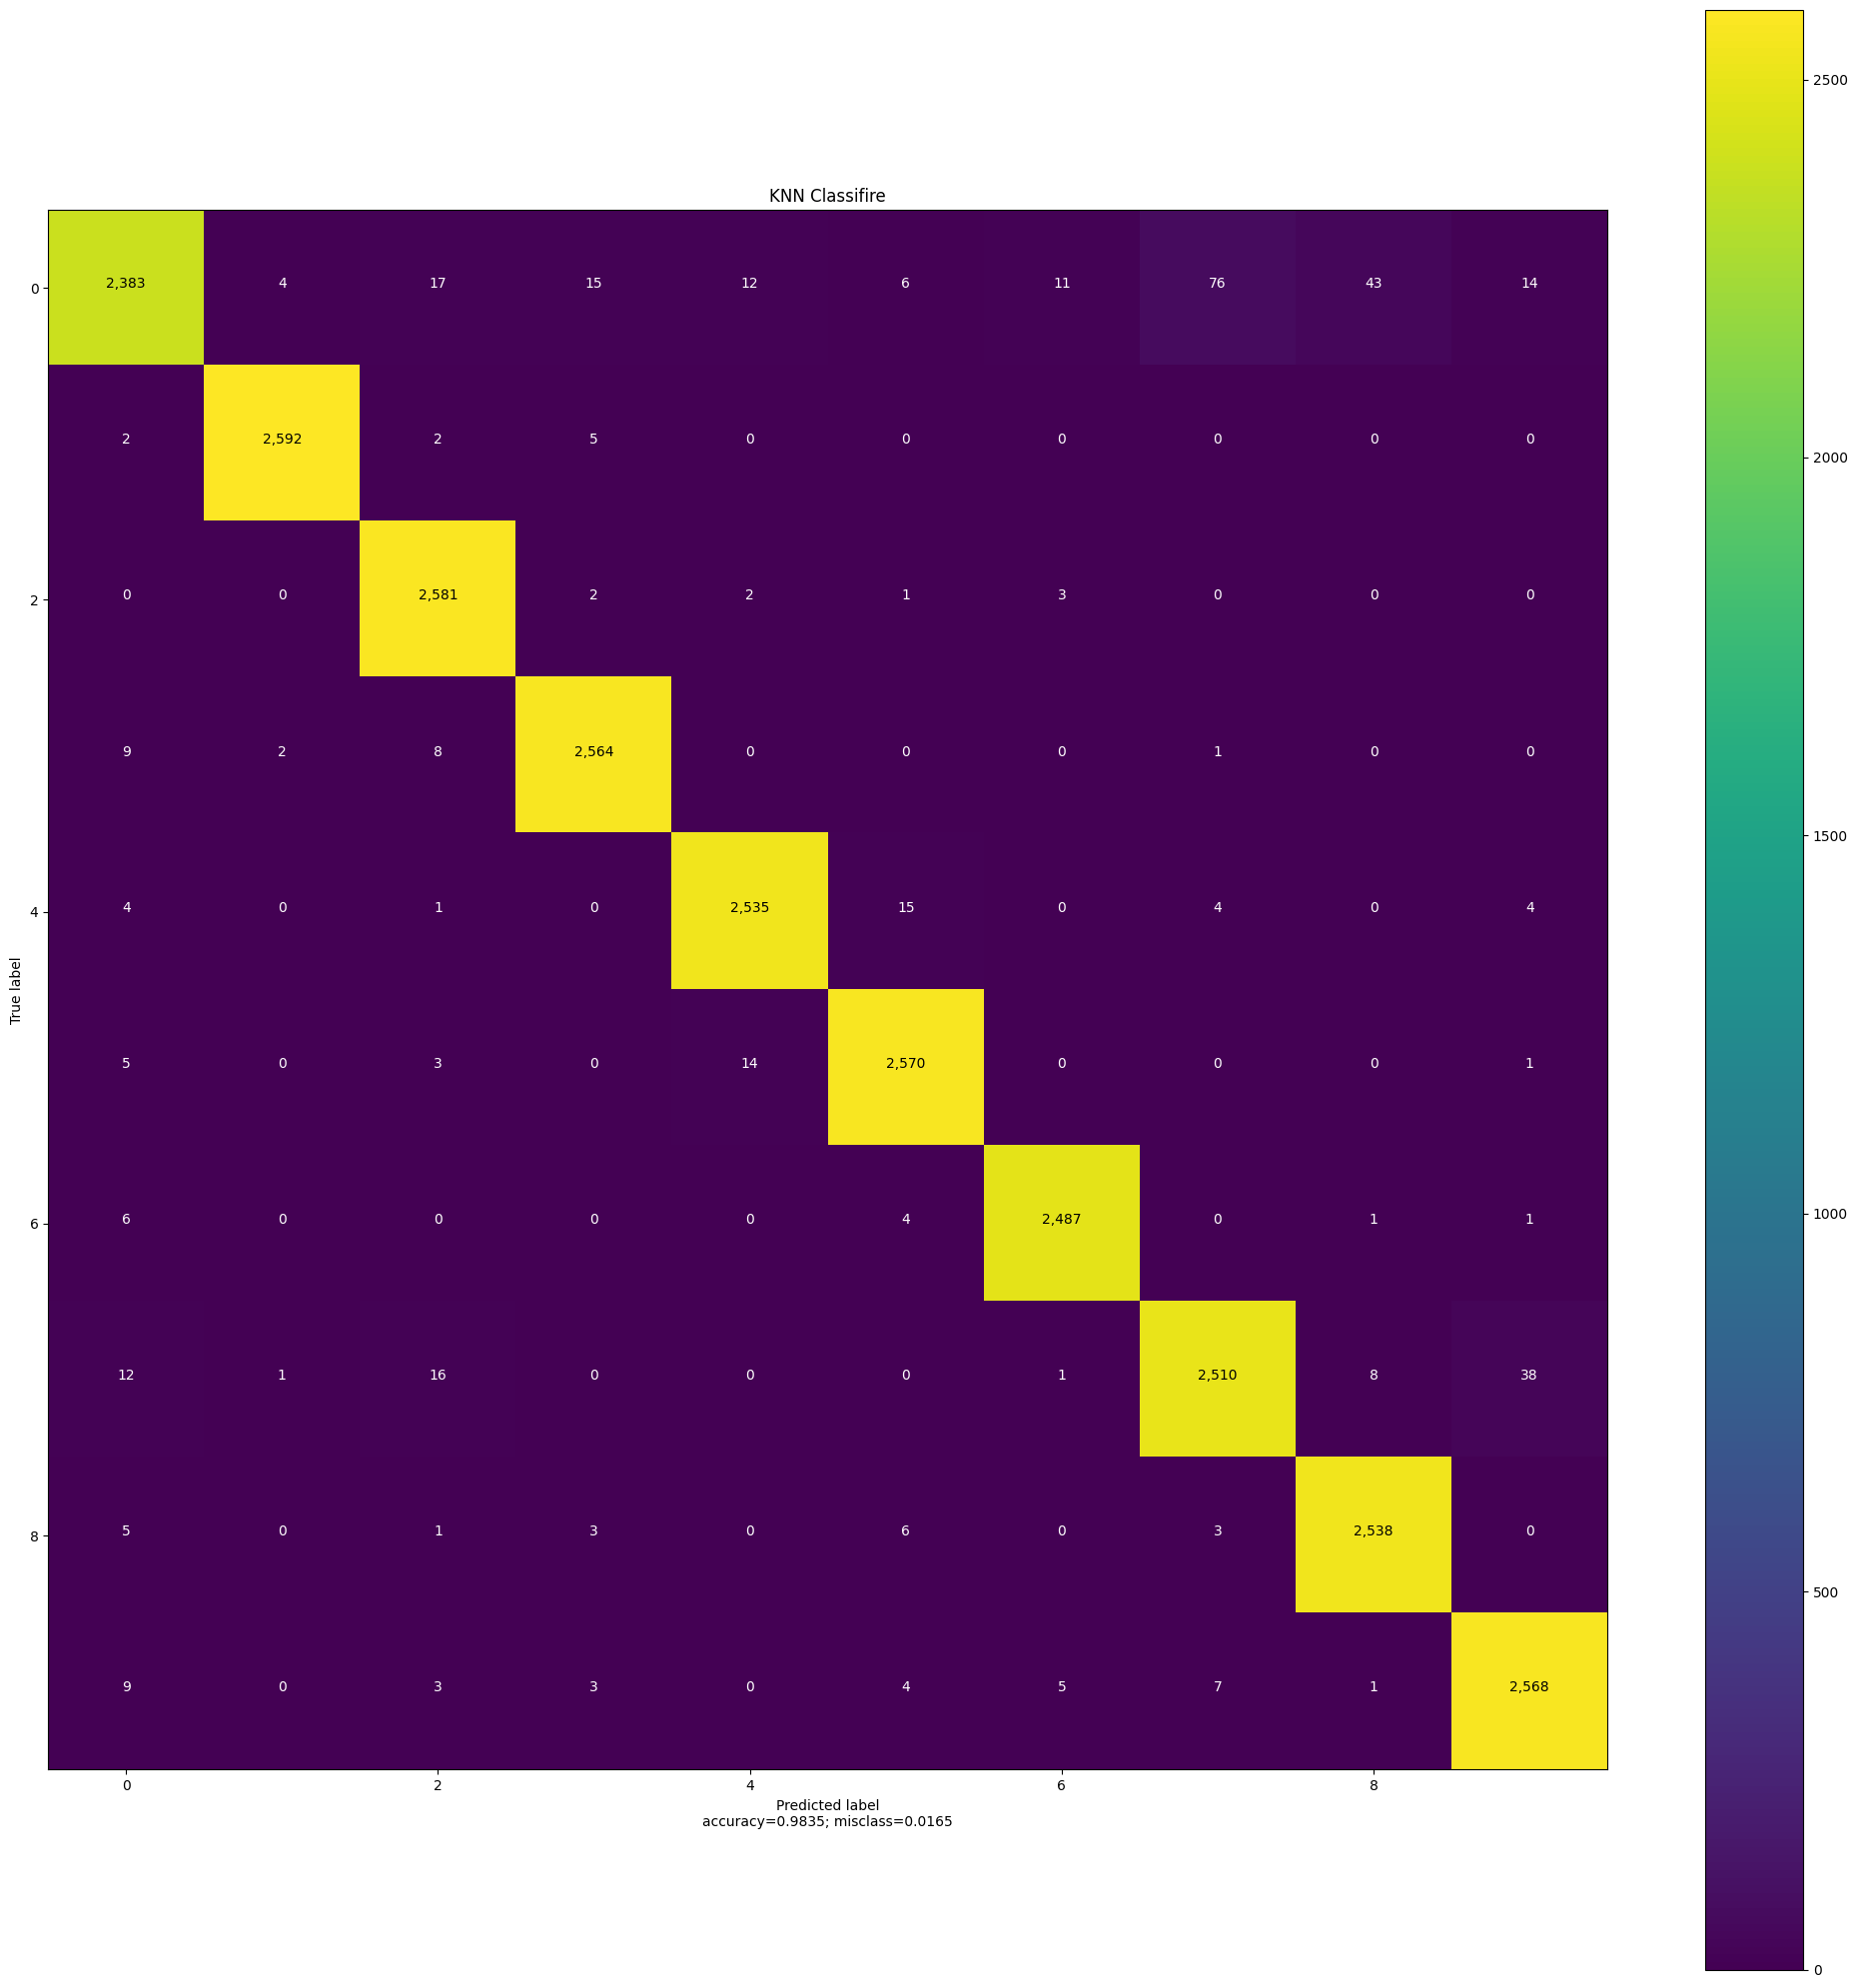

<Figure size 640x480 with 0 Axes>

In [30]:
plot_confusion_matrix(cm=confusion_matrix ,title= 'KNN Classifire')

In [31]:
# performance metrics calculation of our model over test data set
start = time.time()
Predict_X =  knn.predict(X_test)
scores = cross_val_score(knn, X_test, Y_test, cv=7)
accuracy = metrics.accuracy_score(Y_test,Predict_X)
confusion_matrix = metrics.confusion_matrix(Y_test, Predict_X)
classification = metrics.classification_report(Y_test, Predict_X, digits=3)
print("Time taken to for performance matric calculation: ", time.time()-start," seconds")

Time taken to for performance matric calculation:  1.2910170555114746  seconds


In [32]:
print()
print('--------------------------- Results --------------------------------')
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification)
print()


--------------------------- Results --------------------------------

Cross Validation Mean Score:
 0.9568192877756676

Model Accuracy:
 0.9827586206896551

Confusion matrix:
 [[588   2   6   4   5   4   1  13  11   4]
 [  2 614   1   1   0   0   0   0   0   0]
 [  0   0 629   1   0   0   0   0   0   0]
 [  0   0   2 633   0   0   0   0   0   0]
 [  2   0   0   0 642  10   0   2   0   0]
 [  1   0   0   0   2 621   0   2   0   0]
 [  1   0   0   0   0   0 718   0   0   1]
 [  4   0   4   1   0   0   0 612   1  11]
 [  1   0   1   1   0   0   0   0 660   0]
 [  1   0   2   0   0   0   3   3   0 610]]

Classification report:
                   precision    recall  f1-score   support

          BENIGN      0.980     0.922     0.950       638
            DDoS      0.997     0.994     0.995       618
   DoS GoldenEye      0.975     0.998     0.987       630
        DoS Hulk      0.988     0.997     0.992       635
DoS Slowhttptest      0.989     0.979     0.984       656
   DoS slowloris  

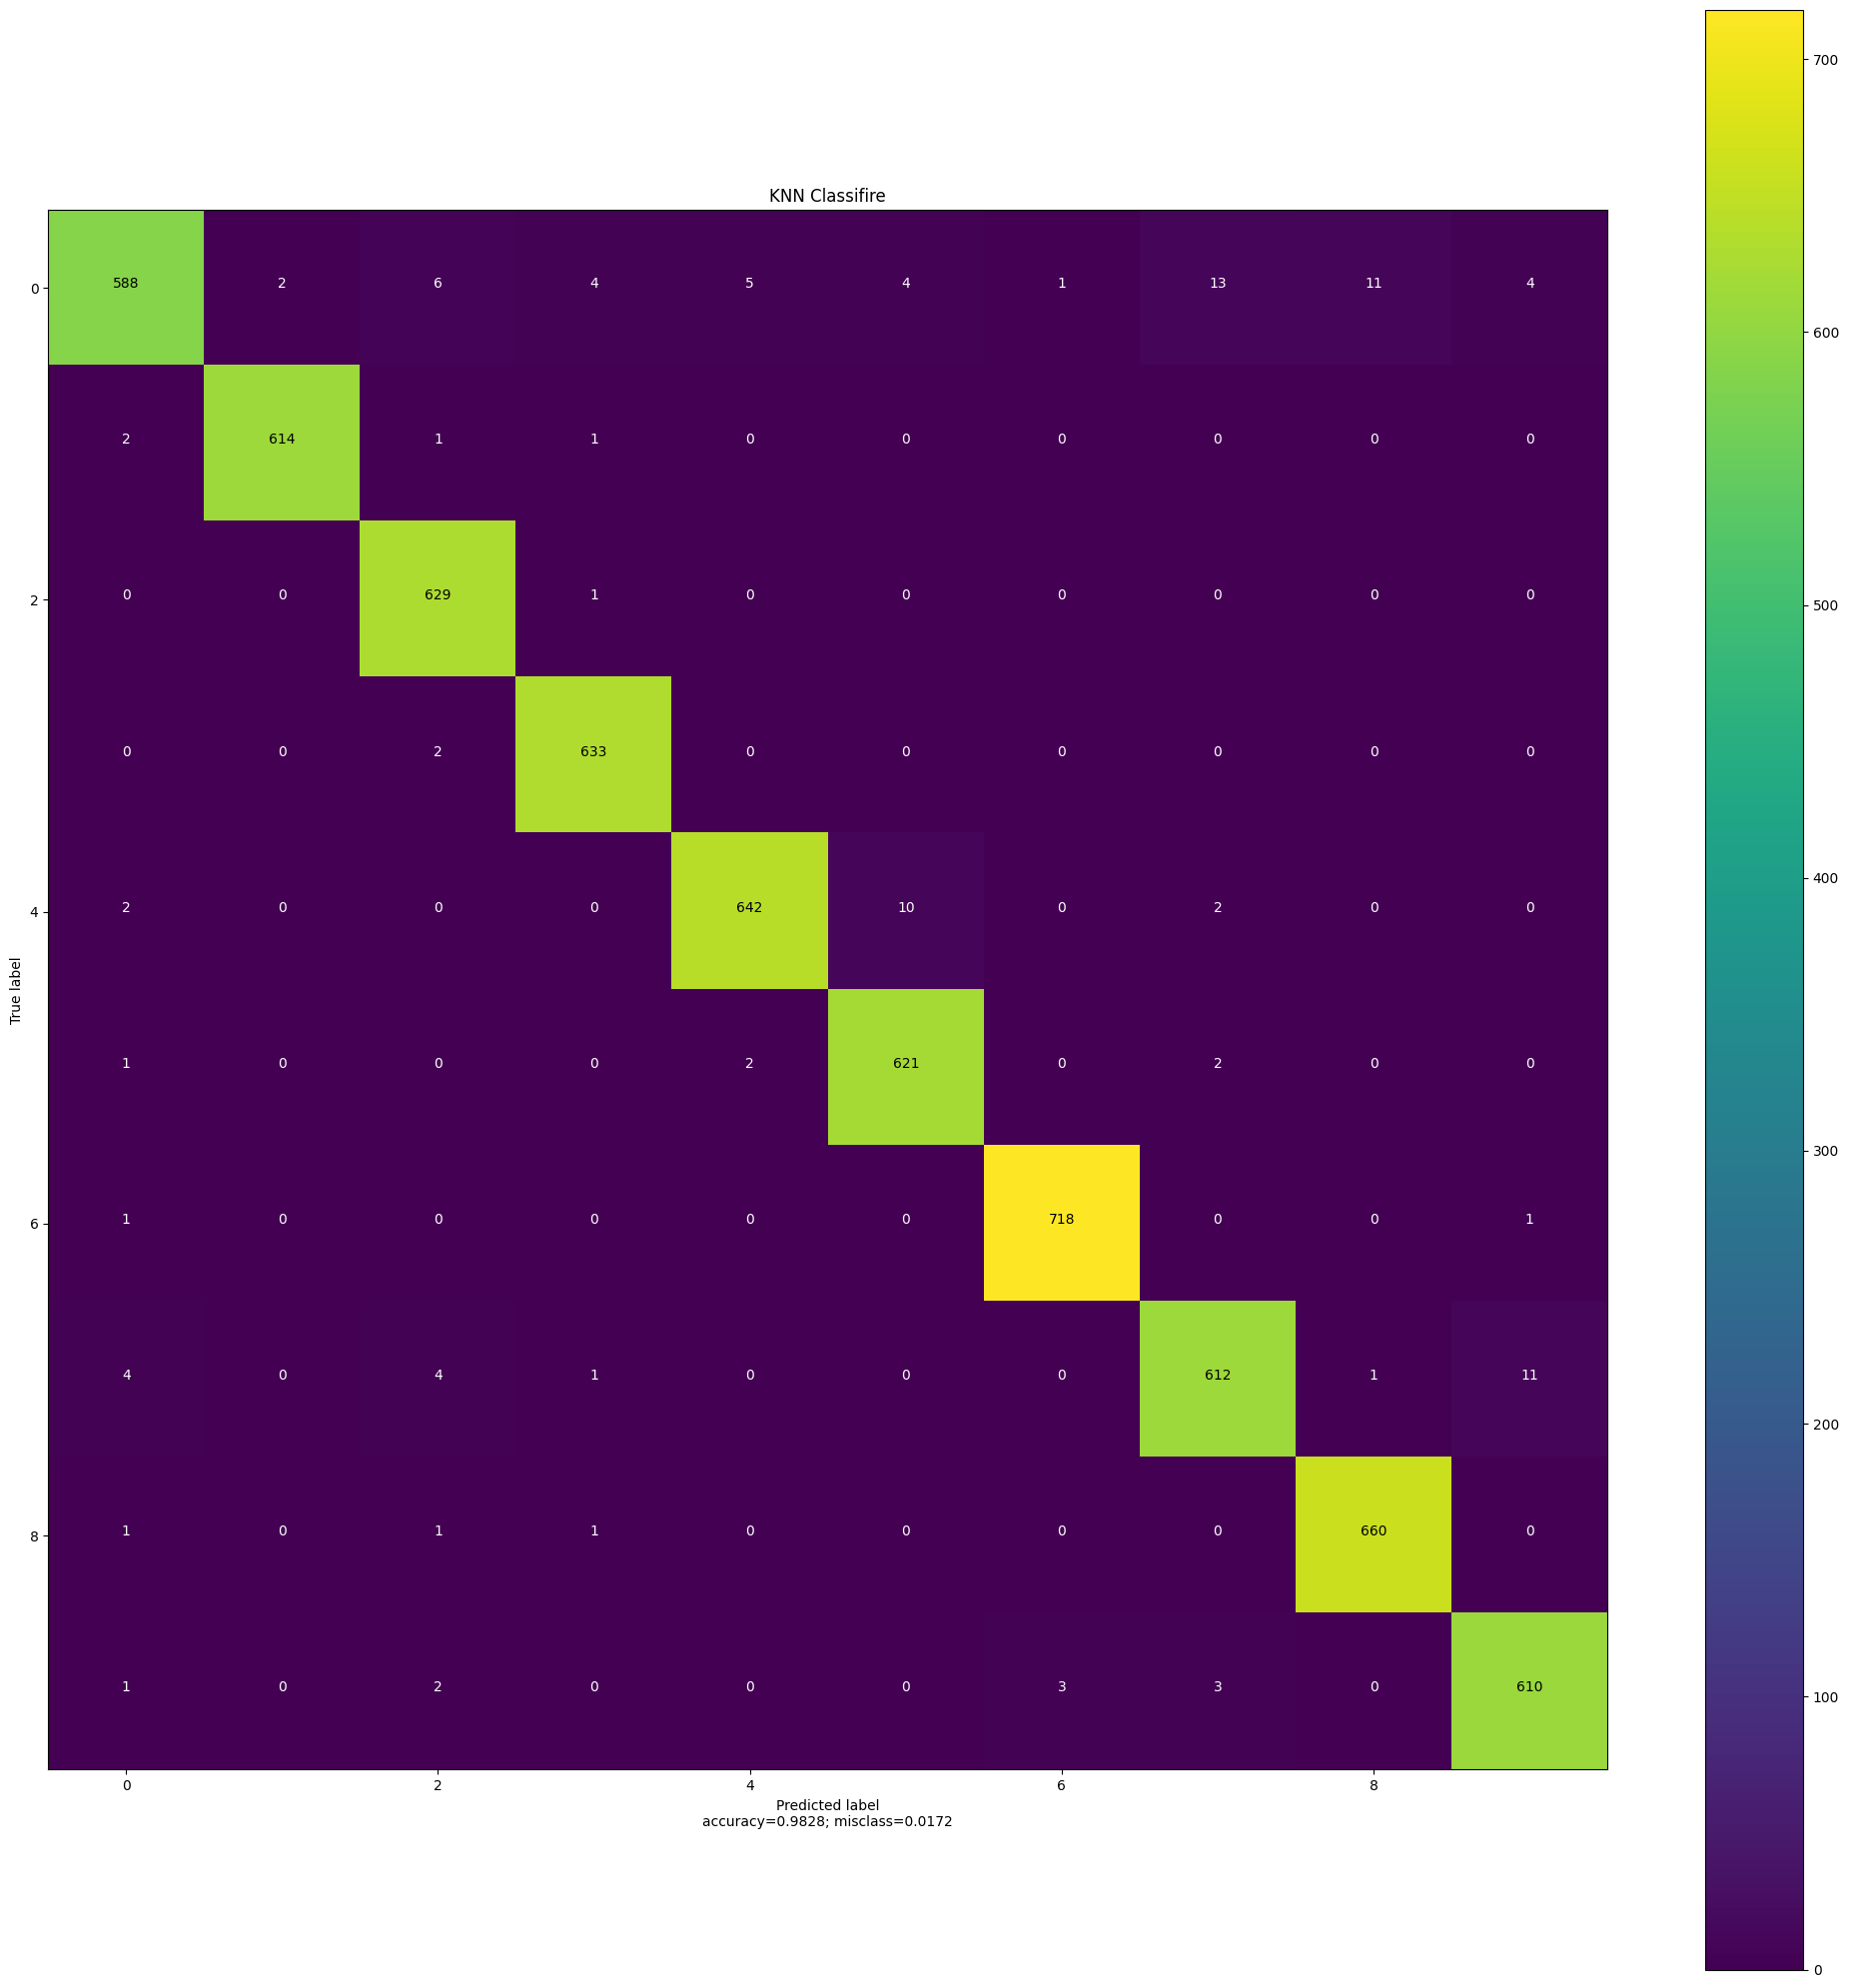

<Figure size 640x480 with 0 Axes>

In [33]:
plot_confusion_matrix(cm=confusion_matrix ,title= 'KNN Classifire')

In [34]:
# %% [Lưu mô hình]
import joblib

# Lưu mô hình KNN đã huấn luyện
joblib.dump(knn, 'knn_model.joblib')
print("Model saved as 'knn_model.joblib'")


Model saved as 'knn_model.joblib'
